### Projection Rectification
#### Theory
Projection rectification is the process of undoing distortions to shapes, caused by projecting a 3D object down to a 2D image.
Projection rectification can be achieved in several way, the simplest way is:

- Marking 4 points in the original image, preferrably of a recognizable shape, like a square
- Specifying the new coordinate of the 4 points that we want
- Solving for the projective transformation.

Suppose points are $x_1, x_2, x_3, x_4$ and $x_1', x_2', x_3', x_4'$, then: 
$$
Hx_i = x_i' \to H\cdot [x_1 \ x_2 \ x_3 \ x_4] = [x_1' \ x_2' \ x_3' \ x_4']
$$

Problem: $H$ is 3x3, but $[x_1 \ x_2 \ x_3 \ x_4]$ and $[x_1' \ x_2' \ x_3' \ x_4']$ are 3x4. This is because $x_i$ are given in projective coordinates that is defined only up to scale.



Approach 1: Dirty fix. Take advantage of $x_i' \times Hx_i = 0$ (Ref: p89)
Flatten H as
$$
H = 
\begin{bmatrix}
        h_1  & h_2 & h_3\\
        h_4  & h_5 & h_6\\
        h_7  & h_8 & h_9\\
\end{bmatrix}
\to
\mathbf{h}
    = \begin{bmatrix}
        \vec h_1  \\
        \vec h_2 \\
        \vec h_3 
    \end{bmatrix}_{9 \times 1} = \begin{bmatrix}
         h_1 \\
         h_2 \\
         h_3 \\
         h_4 \\
         h_5 \\
         h_6 \\
         h_7 \\
         h_8 \\
         h_9 \\
    \end{bmatrix}_{9 \times 1}
$$
Where $h_i$ is the $i$-th row of $H$ transposed, of dimension $3 \times 1$, and 
$\mathbf{x_i}^T = (x_i, y_i, w_i)$
Then the equation becomes
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
        -y_i'\mathbf{x_i^T} & x_i'\mathbf{x_i^T} & 0^T
\end{bmatrix}_{3 \times 9} h = \mathbf{0}
$$
Since H is defined up to scale, the last row is ommitted: 
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
\end{bmatrix}_{2 \times 9} h = \mathbf{0} \to A_ih = 0
$$ 
Each $i$ gives two equations for a total of 8 equations. This can be solved by locking $h_9$ = 1 because of projective coordinates, but this is a dirty solution (we'll see why)

#### Step 1. Determining 4 corresponding points

In [1]:
%matplotlib inline
# Load image, put on plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image = plt.imread('../images/floor.jpg')
# Display the image

# selecting 4 points, put them on the image
x = np.array([[132,379], [198, 435], [276,370], [210, 327]])
x_coords, y_coords = zip(*x)


# And the corresponding points where we want them to be after the distortion undo
x_prime = np.array([[200, 300], [300, 300], [300, 200], [200,200]])


xp_coords, yp_coords = zip(*x_prime)


(480, 480, 3)


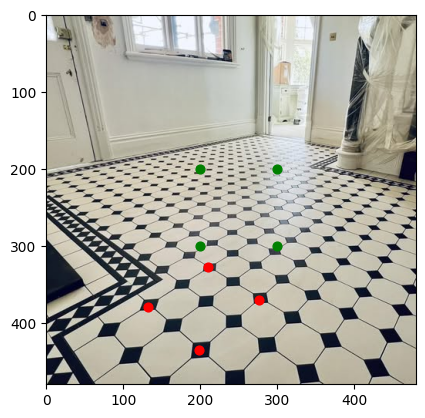

In [2]:
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(image)
print(image.shape)
ax.scatter(x_coords, y_coords, color="red", s=40)
ax.scatter(xp_coords, yp_coords, color="green", s=40)

#### Step 2: Solve H

In [3]:
# form the matrix Ai according to definition in Theory
def get_Ai(x, xp, homogen=False):
    # convert x_i, xp_i to homogeneous coords
    if not homogen:
        x_i = np.concatenate((x, [1]))
        xp_i = np.concatenate((xp, [1]))
    else:
        x_i = x
        xp_i = xp
    row1 = np.concatenate((
        np.zeros(3),
        -xp_i[-1]*x_i,
        xp_i[1]*x_i
    )
    )
    row2 = np.concatenate((
         xp_i[-1]*x_i,
         np.zeros(3),
         -xp_i[0]*x_i
    ))
    return np.array([row1, row2])

# Stack the A_i to get A

def get_A(x, x_prime, homogen=False):
    A = np.zeros((0,9))
    for i in range(x.shape[0]):
        Ai = get_Ai(x[i], x_prime[i], homogen)
        A = np.concatenate((A,Ai))
    return A


In [4]:

A = get_A(x, x_prime)
b = np.zeros(9)
# Enforce h_9 = 1 
A = np.concatenate((A, [[0,0,0,0,0,0,0,0,1]]))
b[-1] = 1

# solve for H
h = np.linalg.solve(A, b)
print(h)
# reshape h into H
H = h.reshape((3,3))
print(H)

[ 5.18381985e+00  1.08834498e+01 -3.42926401e+03 -4.36883333e+00
  9.82204387e+00 -1.07612710e+03  1.42883678e-05  1.55600326e-02
  1.00000000e+00]
[[ 5.18381985e+00  1.08834498e+01 -3.42926401e+03]
 [-4.36883333e+00  9.82204387e+00 -1.07612710e+03]
 [ 1.42883678e-05  1.55600326e-02  1.00000000e+00]]


Confirm that x had been transformed to x_prime

In [5]:
x_p = H @ (np.hstack((x, np.ones((4,1))))).T
# convert back to (x, y, 1) form
x_p = x_p * 1/x_p[-1]
x_p = x_p[:-1, :].reshape((-1, 2))

In [6]:
print(x)
print(x_p)

[[132 379]
 [198 435]
 [276 370]
 [210 327]]
[[200. 300.]
 [300. 200.]
 [300. 300.]
 [200. 200.]]


#### Step 3. Apply H on the image

**Caution!**

A perk of the warp function here is that it applies the INVERSE of the transform that it estimates! Meaning if $H$ transform source points to destination points, then warp(image, H) applies $H^{-1}$ on the image! So we actually have to invert H before giving to this function that does the pixel mapping for us.

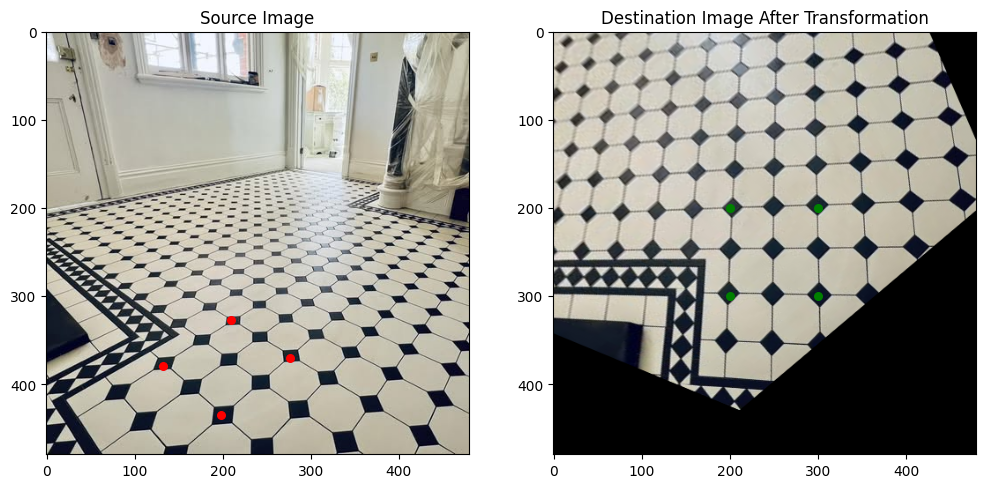

In [7]:
%matplotlib inline
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, warp
import numpy as np

im_src = imread('../images/floor.jpg')
height, width, dim = im_src.shape
im_dst = np.zeros((height, width, dim))

# funny perk of warp: it applies inverse of H to the image
H_inv = np.linalg.inv(H)

im_dst = warp(im_src, H_inv, output_shape=(height, width))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)
x_coords, y_coords = zip(*x)
plt.scatter(x_coords, y_coords, s=30, color="red")
plt.title('Source Image')
plt.subplot(122)
plt.imshow(im_dst)
x_coords, y_coords = zip(*x_p)
plt.scatter(x_coords, y_coords, s=30, color="green")
plt.title('Destination Image After Transformation')
plt.show()

#### Commercial solution

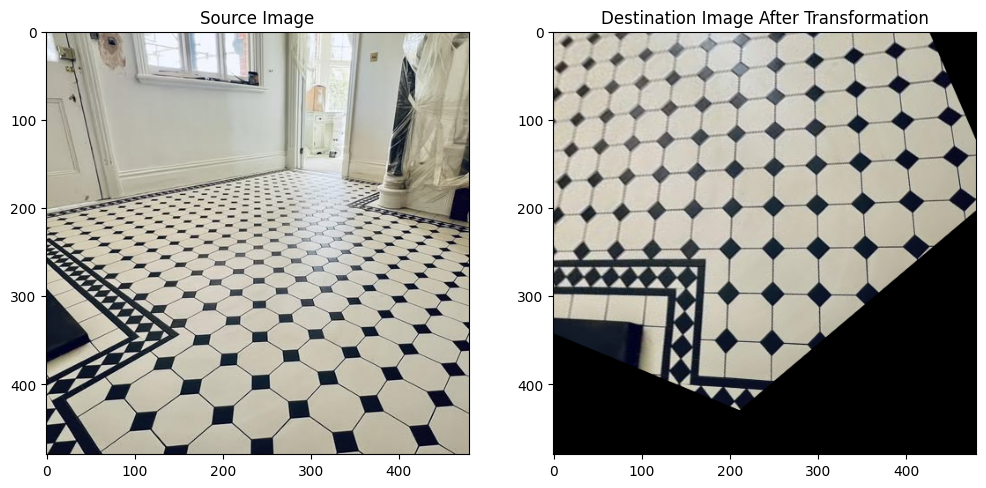

In [8]:
%matplotlib inline
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, warp
import numpy as np

im_src = imread('../images/floor.jpg')
height, width, dim = im_src.shape
im_dst = np.zeros((height, width, dim))

pt = ProjectiveTransform()

pt.estimate(x_prime, x)

im_dst = warp(im_src, pt, output_shape=(height, width))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)
ax.scatter(x_coords, y_coords, color="red", s=40)
ax.scatter(xp_coords, yp_coords, color="green", s=40)
plt.title('Source Image')
plt.subplot(122)
plt.imshow(im_dst)
plt.title('Destination Image After Transformation')
plt.show()

#### Compute using horizon lines 
The horizon line, also called the *line at infinity*, gives a way to intuitively make sense of the transform. Since points and lines both deliver 2 equations, we'll use two points at infinity instead of 1 line at infinity as a practicality perk.

Suppose I want to say: "Look at the floor in the above image, but top-down". This is equivalent to "please make paralel lines cut at points of the form (a, b, 0)". 

To achieve that, we'll compute $x^1_\infty$ and $x^2_\infty$ from 2 paralel lines, and specify that we want them to be of the form $x'_\infty = (a, b, 0)$ after the transform. We'll then supply two more points to determine the entire transform. We should also see what kind of effect $a$ and $b$ has by trying a few values.

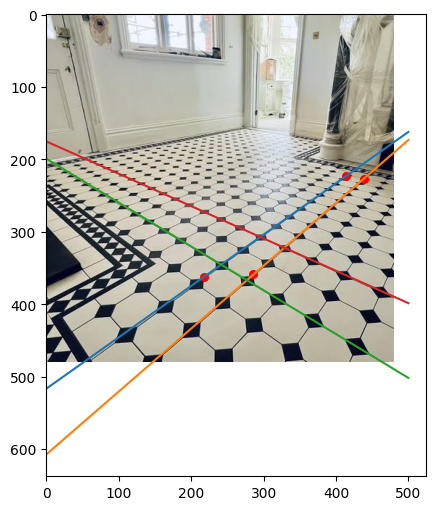

In [32]:
%matplotlib inline
# Choosing points and compute lines
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)

a = np.array([218,362])
b = np.array([414,223])
c = np.array([286,359])
d = np.array([438,227])
# ab // cd

e = np.array([411,448])
f = np.array([69,241])
g = np.array([445, 374])
h = np.array([201,265])
# ef // gh

pts = np.array([a, b, c, d])
x_coords, y_coords = zip(*pts)


ab = np.cross(np.concatenate((a, [1])), np.concatenate((b, [1])))
cd = np.cross(np.concatenate((c, [1])), np.concatenate((d, [1])))
ab = ab*(1/ab[-1])
cd = cd*(1/cd[-1])

ef = np.cross(np.concatenate((e, [1])), np.concatenate((f, [1])))
gh = np.cross(np.concatenate((g, [1])), np.concatenate((h, [1])))
ef = ef*(1/ef[-1])
gh = gh*(1/gh[-1])

x = np.linspace(0, 500, 500)  

# Calculate y-values for plotting
yab =  -(ab[0]* x + ab[2])/ab[1]
ycd =  -(cd[0]* x + cd[2])/cd[1]
yef =  -(ef[0]* x + ef[2])/ef[1]
ygh =  -(gh[0]* x + gh[2])/gh[1]
plt.plot(x, yab)
plt.plot(x, ycd)
plt.plot(x, yef)
plt.plot(x, ygh)
plt.scatter(x_coords, y_coords, s=30, color="red")
plt.show()

#### Experiment with changing the horizon to a new location

In [88]:
# compute line intersection
ef_gh = np.cross(ef, gh)
ab_cd = np.cross(ab, cd)
ef_gh /= ef_gh[-1]
ab_cd /= ab_cd[-1]

# Give a new horizon, in this case move it "up" in the image
efgh_inf = ef_gh + np.array([0, -500 ,0])
abcd_inf = ab_cd + np.array([0, -500 ,0])

pts = np.array([
    np.array([218,362, 1]), np.array([286,359, 1]),
    ab_cd, ef_gh
])

new_pts = np.array([
    np.array([218,362, 1]), np.array([286,359, 1]),
    abcd_inf, efgh_inf
])



In [89]:
# Solve H

A = get_A(pts, new_pts, homogen=True)
b = np.zeros(9)
# Enforce h_9 = 1 
A = np.concatenate((A, [[0,0,0,0,0,0,0,0,1]]))
b[-1] = 1

# solve for H
h = np.linalg.solve(A, b)
print(h)
# reshape h into H
H = h.reshape((3,3))
print(H)

[ 9.48129030e-01  7.43566697e-02 -1.93743651e+01  3.79548438e-02
  2.92081442e+00 -7.09861152e+02 -1.31070857e-04  3.12216696e-05
  1.00000000e+00]
[[ 9.48129030e-01  7.43566697e-02 -1.93743651e+01]
 [ 3.79548438e-02  2.92081442e+00 -7.09861152e+02]
 [-1.31070857e-04  3.12216696e-05  1.00000000e+00]]


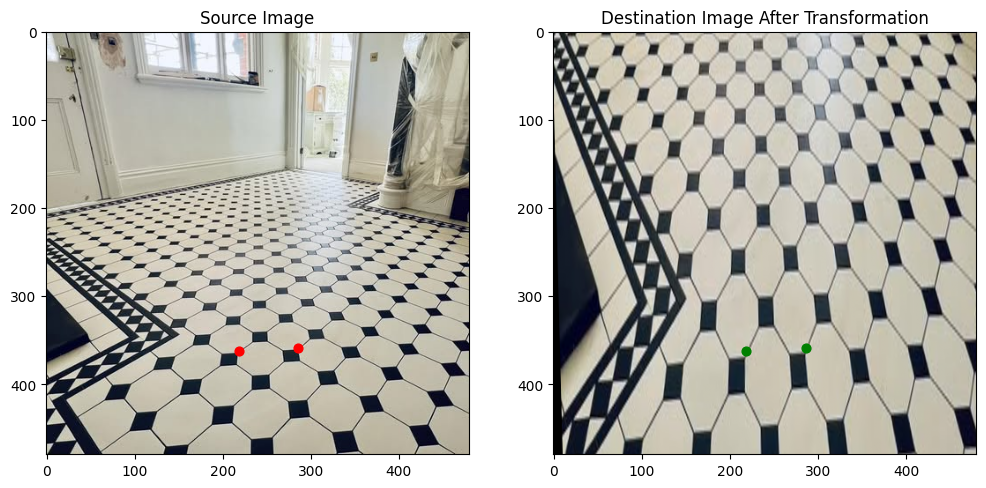

In [90]:
%matplotlib inline
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform, warp
import numpy as np

im_src = imread('../images/floor.jpg')
height, width, dim = im_src.shape

im_dst = warp(im_src, np.linalg.inv(H), output_shape=(height, width))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(im_src)
pts = np.array([a, c])
x_coords, y_coords = zip(*pts)

plt.scatter(x_coords, y_coords, color="red", s=40)
plt.title('Source Image')
plt.subplot(122)
plt.imshow(im_dst)
pts = np.array([a, c])
x_coords, y_coords = zip(*pts)
plt.scatter(x_coords, y_coords, color="green", s=40)
plt.title('Destination Image After Transformation')
plt.show()

##### Interpretation 
Setting the horizon to be more "up" roughly equates to changing the camera angle to look more "down". If we were to move them infinitely far away, we could potentially create the bird's eye view. This gives intuitive meaning to the transformation we are doing: Moving the horizon somewhere, instead of just specifying random points. 

This is ultimately why the concept of line at infinity is needed.

Also note that even if we move the horizon really far away in the y direction, the distortion isn't gone, we have the feeling of a bird's eye view, but the shapes are still distorted. This is because correcting the horizon isnt enough - the horizon is only constant up to *affinity*, and for shapes to be correct we have to find an object that is constant up to *similarity*. Keeping the two extra mapped point constant probably didnt help either - a camera angle change in general changes the position of points, except for very few fixed points. The distortion above that we see is probably caused by trying to keep the two red dots constant
when they shouldn't be, by squeezing the image

It is also not guaranteed that our transformation will have the same effect as a camera angle rotation, since that is a *perspectivity* and we have yet to specify a way to find that.

Thus we learn that even though 4 points is enough to correct any perspective distortion, doing so isn't very interpretable. A lot of projective geometry's job is to find ways to effectively and intuitively communicate things such as "please create a bird's eye view centered at this point".

#### Caution

Another thing to note is if we were to specify the horizon to be $a, b, 0$, i.e truly at infinity, the equation breaks, the A matrix becomes singular. This can be seen by looking at 
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
\end{bmatrix}_{2 \times 9} h = \mathbf{0} \to A_ih = 0
$$

and setting $w'_i = 0$. Two equations collapse to 1, leading to a singular matrix. This came from the fact that we *made the choice* to omit the third row
$$
 \begin{bmatrix}
        0^T & -w_i' \mathbf{x_i^T} & y_i'\mathbf{x_i^T}  \\
        -w_i' \mathbf{x_i^T} & 0^T & -x_i'\mathbf{x_i^T} \\
        -y_i'\mathbf{x_i^T} & x_i'\mathbf{x_i^T} & 0^T
\end{bmatrix}_{3 \times 9} h = \mathbf{0}
$$

we did that because we assumed everything is defined as a ratio to the third equation - which only makes sense if it isn't 0. Bringing the third row back makes the matrix non singular again. A better way to deal with this is noted in p.128 of reference, or also in 'projection_rectification_n_points.ipynb'